## Description

## Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import log_loss
import dask.dataframe as dd
import matplotlib.pyplot as plt

## Versions

## Get Data

In [2]:
path = '/Users/davidziganto/data/'

#X_train = pd.read_hdf(path + 'raw_HIGGS_training_data.h5', 'table')
#y_train = X_train.pop('label')

X_test = pd.read_hdf(path + 'raw_HIGGS_test_data.h5', 'table')
y_test = X_test.pop('label')

#### Dask

In [3]:
df = dd.read_hdf('/Users/davidziganto/data/for_iterating/*.h5', key='/*')

In [4]:
dask_dict = {i: df.get_partition(i) for i in range(df.npartitions)}

## Online Learning

#### Instantiate Models

In [5]:
nb = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)

lr = SGDClassifier(loss='log', 
                   penalty='elasticnet', 
                   alpha=0.01, 
                   l1_ratio=0.5, 
                   fit_intercept=True, 
                   n_iter=1, 
                   shuffle=False, 
                   verbose=1, 
                   epsilon=None, 
                   n_jobs=-1, 
                   random_state=123, 
                   learning_rate='optimal',
                   eta0=0.0, 
                   power_t=0.5, 
                   class_weight=None,
                   warm_start=False, 
                   average=True)

#### Mini-Batch (by partition)

In [6]:
# Find a better way to separate X_train and y-train!!!

ss = StandardScaler()
logloss = []
for k,v in dask_dict.items():
    X_train = df.loc[:, v.columns != 'label']
    y_train = df.loc[:, 'label']
    ss.partial_fit(X_train)
    lr.partial_fit(ss.transform(X_train), y_train, classes=range(2))
    print('Test log loss: %.4f' % log_loss(y_test, lr.predict_proba(ss.transform(X_test))))
    logloss.append(log_loss(y_test, lr.predict_proba(ss.transform(X_test))))
    print('\n')

-- Epoch 1
Norm: 1.83, NNZs: 16, Bias: 0.117786, T: 8800000, Avg. loss: 0.642882
Total training time: 3.75 seconds.
Test log loss: 1.6782


-- Epoch 1
Norm: 1.42, NNZs: 16, Bias: 0.119119, T: 8800000, Avg. loss: 0.642745
Total training time: 2.76 seconds.
Test log loss: 1.1093


-- Epoch 1
Norm: 1.27, NNZs: 16, Bias: 0.119668, T: 8800000, Avg. loss: 0.642781
Total training time: 3.65 seconds.
Test log loss: 0.9194


-- Epoch 1
Norm: 1.18, NNZs: 16, Bias: 0.119823, T: 8800000, Avg. loss: 0.642817
Total training time: 2.43 seconds.
Test log loss: 0.8297


-- Epoch 1
Norm: 1.13, NNZs: 16, Bias: 0.119487, T: 8800000, Avg. loss: 0.642853
Total training time: 3.86 seconds.
Test log loss: 0.7795


-- Epoch 1
Norm: 1.09, NNZs: 16, Bias: 0.118557, T: 8800000, Avg. loss: 0.642889
Total training time: 3.62 seconds.
Test log loss: 0.7483


-- Epoch 1
Norm: 1.06, NNZs: 16, Bias: 0.117056, T: 8800000, Avg. loss: 0.642925
Total training time: 4.54 seconds.
Test log loss: 0.7274


-- Epoch 1
Norm: 1.0

## Plot Log Loss on Test Set

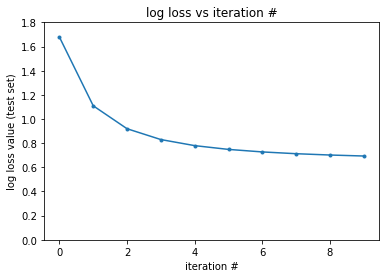

In [21]:
plt.plot(range(10), logloss, '.-')
plt.xlabel('iteration #')
plt.ylabel('log loss value (test set)')
plt.ylim(0,1.8)
plt.title('log loss vs iteration #');

# To do

* find more efficient way to split features and target
* get pipeline working with single large file
* add PCA
* optimize for performance